# **我的 ❤️ 节奏**

**3 张图 + 100 首歌：网易云音乐全部时间累积听歌排行前100首歌的BPM（Beats per Minute)，100首歌名词云图，100首歌曲音乐人词云图，下载到本地的100首歌**

<img src="./img/MyBPM.png" >
<div style="display:flex">
    <div style="display:inline-block;margin:0 1rem">
        <img src="./img/song100.JPG" width=100% height=100%>
    </div>
    <div style="display:inline-block;margin:0 1rem">
        <img src="./img/singer100.JPG" width=100% height=100%>
    </div>
</div>



### **1. 爬取网易云音乐我的听歌排行（全部时间）前100首歌**

从网页上爬取100首歌的歌曲名、歌曲id、歌手名等信息；下载100首歌到本地


<div class="alert alert-block alert-warning">
<b>说明：</b>以下是导入依赖的python库，只需点击运行使其生效即可
</div>

In [117]:
"""
导入需要的 Python 库
""" 
# hashlib、Crypto 包与加密相关，click 与进度条相关，re 与正则表达式相关，base64 编码解码相关
# binascii 二进制与ASCII之间的转换
# requests, selenium, bs4 爬虫用
# pydub 用来切割音乐，librosa 用来分析音乐节拍
# matplotlib，seaborn，PIL，wordcloud 用来作图或处理图片

# librosa 安装：
# 如果使用 conda，直接 conda install librosa 一步完事；
# 如果使用 pip，win或os用户两步完事：pip install soundfile, pip install librosa
# 如果使用 pip，linux 用户三步完事...sudo apt install libsndfile1, pip install soundfile, pip install librosa


import time
import requests
import hashlib
import sys
import click
import re
import base64
import binascii
import json
import os
import pydub
import librosa 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib
import subprocess
from PIL import Image
from wordcloud import WordCloud
from Crypto.Cipher import AES   # PyCryptodome 包
from http import cookiejar
from bs4 import BeautifulSoup
from selenium import webdriver 
from pydub import AudioSegment
from collections import Counter

                                
"""
matplot默认字体不支持中文，会乱码，所以需要明确指定支持中文的字体；可以先查看它内置了哪些字体，选出中文的就可以了
a = sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])
for i in a:
    print(i)
"""

matplotlib.rc("font",family='Source Han Serif CN')       

In [ ]:
# 爬取听歌排行网页信息时需要使用 selenium，这个包还需要根据不同的浏览器安装相应的 driver，这里下载使用火狐浏览器对应的 geckodriver
# 因为要爬取的信息写在 iframe 内，使用 requests 很难直接拿到，selenium 看起来容易很多，就是装 driver 麻烦些

command1 = "wget https://github.com/mozilla/geckodriver/releases/download/v0.24.0/geckodriver-v0.24.0-linux64.tar.gz"
command2 = "tar -xvzf geckodriver*"
command3 = "chmod +x geckodriver"
command4 = "sudo mv geckodriver /usr/local/bin/"

subprocess.call(command1, shell = True)
subprocess.call(command2, shell = True)
subprocess.call(command3, shell = True)
subprocess.call(command4, shell = True)

<div class="alert alert-block alert-warning">
<b>说明：</b>以下两栏是定义类，只需点击运行使其生效即可
</div>

In [5]:
class Encrypyed():
    """
    解密算法（数据是要从网易云的服务器中获得的，为了获得他们，就需要向服务器提请求，由于数据是不能被外部轻易获得的，
    因此索要数据的请求就是加密的。这个算法就是要帮我们伪装索要数据的请求。以上是我目前连蒙带猜的理解...待求证）
    
    这个类的代码可以不用修改直接用，不理解也没影响，后面向网易云服务器提需求（post或get）以查找歌曲id或下载歌曲时，
    会基于下面这个 encrypted_request() 函数
    
    直接搬自https://github.com/Jack-Cherish/python-spider/blob/master/Netease/Netease.py，感谢
    """
    def __init__(self):
        self.modulus = '00e0b509f6259df8642dbc35662901477df22677ec152b5ff68ace615bb7b725152b3ab17a876aea8a5aa76d2e417629ec4ee341f56135fccf695280104e0312ecbda92557c93870114af6c9d05c4f7f0c3685b7a46bee255932575cce10b424d813cfe4875d3e82047b97ddef52741d546b8e289dc6935b3ece0462db0a22b8e7'
        self.nonce = '0CoJUm6Qyw8W8jud'
        self.pub_key = '010001'

    # 登录加密算法, 基于https://github.com/stkevintan/nw_musicbox脚本实现
    def encrypted_request(self, text):
        text = json.dumps(text)
        sec_key = self.create_secret_key(16)
        enc_text = self.aes_encrypt(self.aes_encrypt(text, self.nonce), sec_key.decode('utf-8'))
        enc_sec_key = self.rsa_encrpt(sec_key, self.pub_key, self.modulus)
        data = {'params': enc_text, 'encSecKey': enc_sec_key}
        return data

    def aes_encrypt(self, text, secKey):
        pad = 16 - len(text) % 16
        text = text + chr(pad) * pad
        encryptor = AES.new(secKey.encode('utf-8'), AES.MODE_CBC, b'0102030405060708')
        ciphertext = encryptor.encrypt(text.encode('utf-8'))
        ciphertext = base64.b64encode(ciphertext).decode('utf-8')
        return ciphertext

    def rsa_encrpt(self, text, pubKey, modulus):
        text = text[::-1]
        rs = pow(int(binascii.hexlify(text), 16), int(pubKey, 16), int(modulus, 16))
        return format(rs, 'x').zfill(256)

    def create_secret_key(self, size):
        return binascii.hexlify(os.urandom(size))[:16]

In [6]:
class Mysongs100():
    """
    爬取用户个人主页上的听歌排行（全部时间）数据并下载对应100首歌曲到本地
    
    只有当用户设置公开自己的听歌排行，才能根据用户id爬取信息。
    
    基于https://github.com/Jack-Cherish/python-spider/blob/master/Netease/Netease.py
    和https://blog.csdn.net/u010890916/article/details/106879465/
    感谢
    
    """
    def __init__(self, uid, folder, timeout=60, cookie_path='.'):
        self.headers = {
            'Accept': '*/*',
            'Accept-Encoding': 'gzip,deflate,sdch',
            'Accept-Language': 'zh-CN,zh;q=0.8,gl;q=0.6,zh-TW;q=0.4',
            'Connection': 'keep-alive',
            'Content-Type': 'application/x-www-form-urlencoded',
            'Host': 'music.163.com',
            'Referer': 'http://music.163.com/search/',
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36'
        }
        self.session = requests.Session()
        self.session.headers.update(self.headers)
        self.session.cookies = cookiejar.LWPCookieJar(cookie_path)
        self.download_session = requests.Session()
        self.timeout = timeout
        self.ep = Encrypyed()
        self.folder = './mysongs100' if folder is None else folder
        self.uid = uid  #网易云音乐用户id
        self.url_rec = 'https://music.163.com/#/user/songs/rank?id=' + uid
        self.mysongs100 = []

        

    def post_request(self, url, params):
        """
        Post请求
        :return: 字典
        """

        data = self.ep.encrypted_request(params)
        resp = self.session.post(url, data=data, timeout=self.timeout)
        result = resp.json()
        if result['code'] != 200:
            click.echo('post_request error')
        else:
            return result


    def get_song_url(self, song_id, bit_rate=320000):
        """
        根据歌曲id获得下载地址
        :params song_id: 音乐ID<int>.
        :params bit_rate: {'MD 128k': 128000, 'HD 320k': 320000}
        :return: 歌曲下载地址
        """

        url = 'http://music.163.com/weapi/song/enhance/player/url?csrf_token='
        csrf = ''
        params = {'ids': [song_id], 'br': bit_rate, 'csrf_token': csrf}
        result = self.post_request(url, params)
        # 歌曲下载地址
        song_url = result['data'][0]['url']

        # 歌曲不存在
        if song_url is None:
            click.echo('Song {} is not available due to copyright issue.'.format(song_id))
        else:
            return song_url

    def get_song_by_url(self, song_url, song_name, song_num):
        """
        下载歌曲到本地
        :params song_url: 歌曲下载地址
        :params song_name: 歌曲名字
        :params song_num: 下载的歌曲数
        :params folder: 保存路径
        """
        if not os.path.exists(self.folder):
            os.makedirs(self.folder)
        fpath = os.path.join(self.folder, str(song_num) + '_' + song_name + '.mp3')
        if sys.platform == 'win32' or sys.platform == 'cygwin':
            valid_name = re.sub(r'[<>:"/\\|?*]', '', song_name)
            if valid_name != song_name:
                click.echo('{} will be saved as: {}.mp3'.format(song_name, valid_name))
                fpath = os.path.join(self.folder, str(song_num) + '_' + valid_name + '.mp3')

        if not os.path.exists(fpath):
            resp = self.download_session.get(song_url, timeout=self.timeout, stream=True)
            length = int(resp.headers.get('content-length'))
            label = 'Downloading {} {}kb'.format(song_name, int(length/1024))
            with click.progressbar(length=length, label=label) as progressbar:
                with open(fpath, 'wb') as song_file:
                    for chunk in resp.iter_content(chunk_size=1024):
                        if chunk:
                            song_file.write(chunk)
                            progressbar.update(1024)
                            
    def get_rec(self):
        """
        打开个人用户页面，获取听歌排行相关信息
        """
        unknown = '未知'  #打印报错用
        driver = webdriver.Firefox()    #不同的浏览器需要下载不同的driver，driver所在路径要加入PATH中      
        driver.get(self.url_rec)
        driver.switch_to_frame('g_iframe')
        driver.implicitly_wait(10)
        checkall = driver.find_element_by_id('songsall')
        checkall.click()
        driver.implicitly_wait(10)
        time.sleep(0.5)
        htmlrec = driver.page_source
        pagerec = BeautifulSoup(htmlrec,'html.parser')
        allrec = pagerec.find(class_= "g-wrap p-prf").find(class_ = "m-record").find(class_ = "j-flag").find_all('li')
        
        try:
            song_num = 0
            mysongs100 = []
            for i in allrec:
            #拿到歌曲名与下载网址，歌曲名可以直接从网页信息中提取，下载网址通过提取歌曲id获得
                ilist = []
                song_num = song_num +1
                print(song_num)
                songinfo = i.find(class_="txt").find('a')
                #print(songinfo) print可以用来观察程序运行到了哪一步
                song_id = int(songinfo.get('href')[9:])
                #print(song_id)
                song_name0 = songinfo.text.replace('\xa0','')  #replace部分是要对提取到的字符串做一些整理，去掉无用的符号
                song_name = song_name0.replace(' ','')
                print(song_name)
                singer = i.find(class_="s-fc8").text.replace(' -','')
                singer_clean = singer.replace('\xa0',' ')
                ilist.append(song_num)
                ilist.append(song_name)
                ilist.append(song_id)
                ilist.append(singer_clean)
                mysongs100.append(ilist) #将每首歌的排序、歌名、id、歌手名存入mysongs100列表中
            
            txt_name = ''
            with open('mysongs100.txt', 'w') as output:      #将列表保存到txt文档中
                for i in mysongs100:
                    print (i,file=output)
                    
            self.mysongs100 = mysongs100
        
        except:
            print('unknown')
    
    
    
    def song_download(self):
        """
        根据allrec中包含的100首歌的歌曲id，逐个搜索下载到本地
        """

        try:
            for i in self.mysongs100:
                song_num = i[0]
                song_name = i[1]
                song_id = i[2]
                song_url = self.get_song_url(i[2])
                print(song_url)                
                
                try:
                    song_download = self.get_song_by_url(song_url,song_name,song_num)
                except:
                    print('no song to be downloaded')                
                time.sleep(3)
               
            print('下载结束')
            

        except:
            print('unknown') 


<div class="alert alert-block alert-danger">
<b>说明：</b> 下面需要你根据自己的情况输入相应信息：网易云音乐用户id，下载歌曲保存在哪个文件夹中。
</div>

In [9]:
# 括号内输入的分别是网易云音乐用户id与下载歌曲保存路径名，这一步是生成一个对象mysongs100，它属于类 Mysongs100
mysongs100 = Mysongs100('网易云id','./mysongs100')  

In [ ]:
# 运行类中的 get_rec() 函数，目的是根据用户id，爬取全部时间听歌排行的歌曲信息，包括歌曲名、累计次数排行、歌手名、歌曲id，结束后会生成一个mysongs100.txt，利用这个文档，后面生成歌手词云图和歌曲词云图
mysongs100.get_rec()           

In [ ]:
# 运行类中的 song_download() 函数，下载歌曲（有资源的）到本地
mysongs100.song_download()      



### **2. 切割音乐，截取前30s片段分析节拍**

<div class="alert alert-block alert-warning">
<b>说明：</b> 下面一栏定义类的代码直接运行即可。
</div>

In [11]:
class Beats():
    """
    切割音乐，默认取每首歌的前30s（为了节省分析歌曲节拍的时间），取分割后的片段分析每首歌的BPM（beats per minutes）
    """
    
    def __init__(self, seconds, seg_path='./mysegsongs100', song_path='./mysongs100'):
        self.seconds = int(seconds)
        self.seg_path = seg_path
        self.song_path = song_path
    
    def songs_segment(self):
        
        """
        利用 PyDub.AudioSegment 切割音乐
        """
        seconds = self.seconds
        song_path = self.song_path
        seg_path = self.seg_path
        if not os.path.exists(seg_path):
            os.makedirs(seg_path)
        mysongs_list = os.listdir(song_path)
        for i in mysongs_list:
            try:
                path = song_path + '/' + i
                song = AudioSegment.from_mp3(path)
                song_seg = song[:seconds*1000]
                print(i+"切割结束")
                expath = seg_path + '/' + i
                song_seg.export(expath)
                print(i+"切割片段已保存")
            except:
                print('切割失败')
        print('全部音乐切割结束')
      
    def beat_track(self):
        
        """
        利用 librosa 分析音乐的节拍，拿到BPM，这部分程序运行耗时最久
        
        需返回tempo_list，后面画图还要用节拍数据
        """
        song_path = self.song_path
        seg_path = self.seg_path
        mysegsongs_list = os.listdir(seg_path)
        tempo_list = []
        for i in mysegsongs_list:
            try:
                ilist = []
                path = song_path + '/' + i
                x, sr = librosa.load(path)
                tempo, beat_times = librosa.beat.beat_track (x, sr=sr, units='time' )
                ilist.append(i)
                ilist.append(tempo)
                tempo_list.append(ilist)
                print(i + '节拍分析完毕')
            except:
                print('节拍分析失败')
        
        with open('tempo_list.txt', 'w') as output:      #将列表保存到txt文档中
            for i in tempo_list:
                print (i,file=output)
        
        return tempo_list



<div class="alert alert-block alert-danger">
<b>说明：</b> 下面需要你根据自己的情况输入相应信息：每首歌截取前多少秒，当前为30。
</div>

In [13]:
# 在 Beats 这个类下生成一个叫做 beat 的对象；30表示切割每首歌的前30s
beat = Beats(30)           

In [ ]:
# 使用类中的songs_segment()函数切割音乐
beat.songs_segment()            

In [ ]:
# 使用类中的beat_track()函数分析音乐节拍，返回一个 tempo_list 列表，下面作图时要使用其中的节拍数据
tempo_list = beat.beat_track()    



### **3. 节拍结果绘图**

<div class="alert alert-block alert-warning">
<b>说明：</b> 下面一栏定义函数的代码直接运行即可。
</div>

In [103]:
def bpm_plot(heartbeat, fig_w=30, fig_h=10, tick_rotation=90, figname='MyBPM.png'):

    """
    利用 matplot 绘制 bar 图，显示所有歌曲的BPM，红色横线对应的是心跳的BPM（每分钟跳动次数）
    
    图中如有汉字需将matplot默认字体改为中文字体，否则乱码，这里使用的是思源宋体
    
    图片保存的清晰度可选，dpi最高300，当前为100
    """
        
    #因为前面使用的os.listdir()没有按照文件夹中文件实际的顺序列举提取文件，所以上一步中分析并保存节拍生成的最终列表中，歌曲
    #及对应节拍不是按听歌次数多少降序排列的，为了作图时有序呈现，这里需要对所有歌曲按song_num重新排序
    #x[0]表示tempo_list每个元素列表的第0个元素，即歌曲名，然后再对这个字符串做分割，分割符是下划线‘_’，最后的那个[0]
    #表示取分割后第一个部分，即下划线前面的数字(song_num)，然后对整个tempo_list列表中的元素按这个key做排序
    tempo_list.sort(key=lambda x:int(x[0].split('_')[0]))  
                                       
    langs = []
    tempo = []
    for i in tempo_list:
        index = i[0].find('_')+1
        song_name=i[0][index:-4]
        langs.append(song_name)
        tempo.append(i[1])
                                                    
    
    fig, ax = plt.subplots(figsize=(fig_w,fig_h))
    ax.bar(langs,tempo, color='#4A1942')                                                                 
    ax.set_xlabel('我的100首歌')
    ax.set_ylabel('BPM, Beats per Minute')
    ax.set_title("我的♥节奏")
    ax.hlines(heartbeat,0,1,transform=ax.get_yaxis_transform(),colors='r')    # 心跳BPM， 每分钟心跳多少下
    for tick in ax.get_xticklabels():
        tick.set_rotation(tick_rotation)  #歌名太长，只有旋转90度竖着才能不重叠地呈现
    fig.align_labels()         
    plt.savefig(figname,dpi=100,bbox_inches='tight')
    plt.show()
  


<div class="alert alert-block alert-danger">
<b>说明：</b> 下面运行这个函数，根据自己的情况输入值，至少要输入心跳BPM（每分钟心跳次数），当前是65
</div>

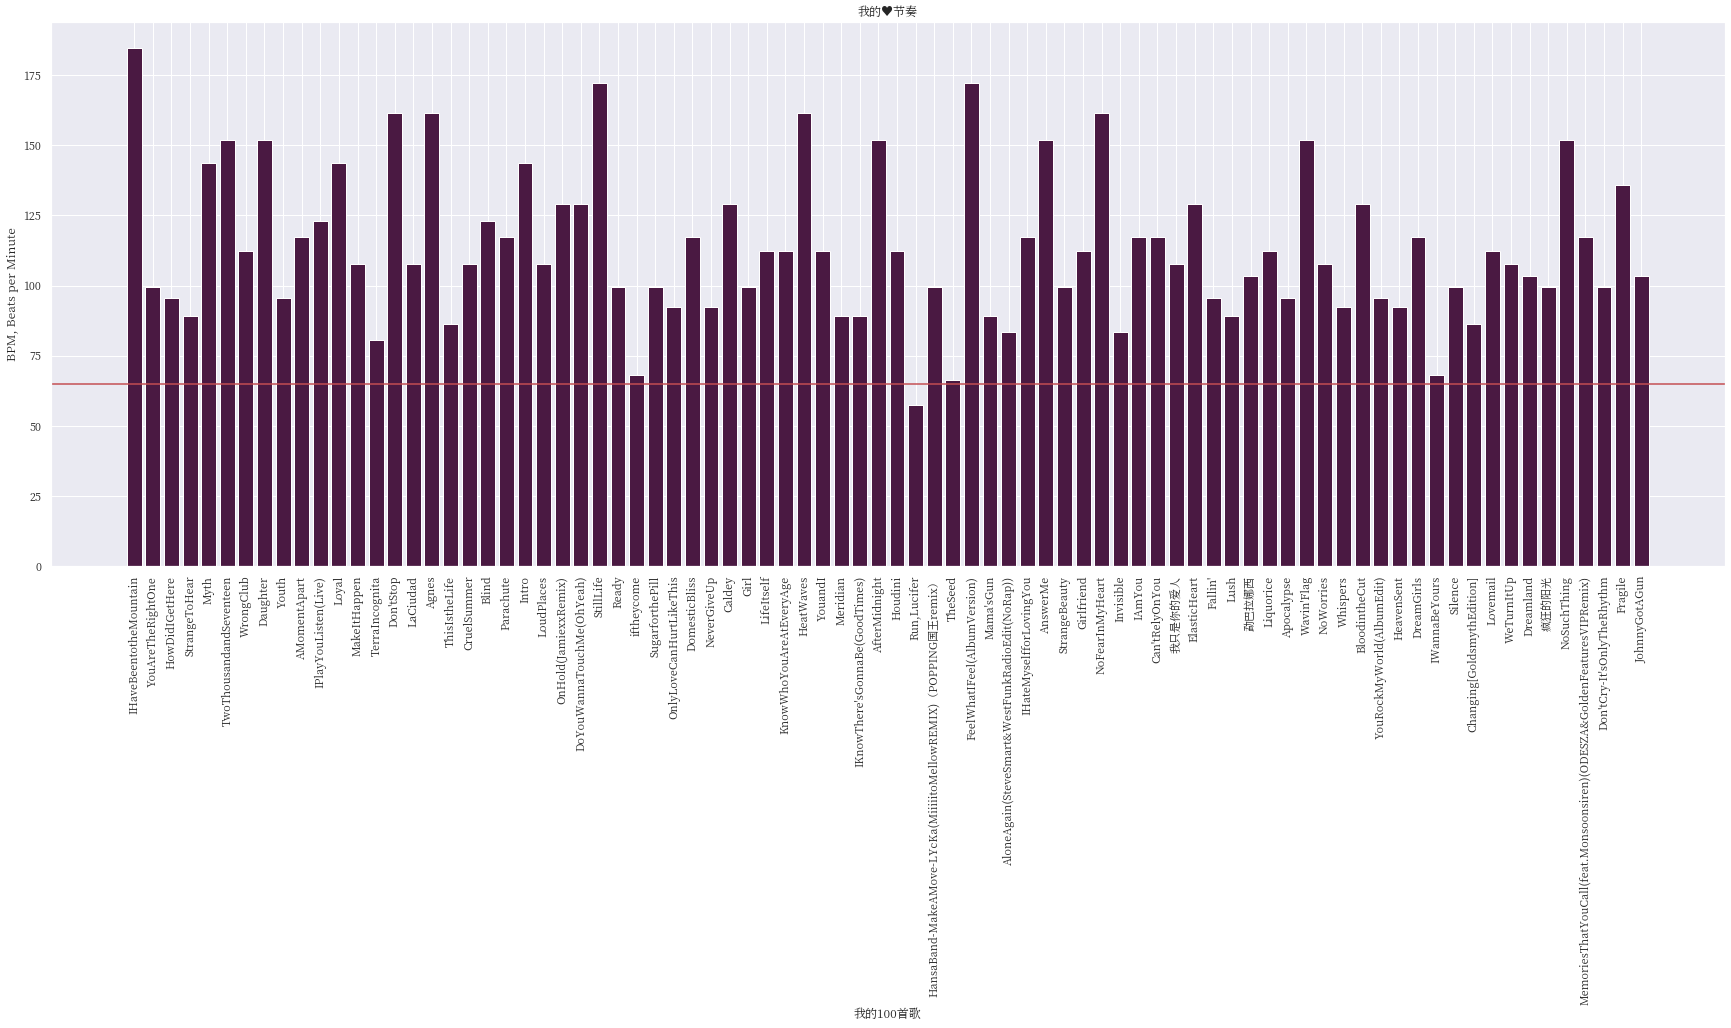

In [104]:
bpm_plot(65)



### **4. 歌曲歌手词云**

**歌手词云**

<div class="alert alert-block alert-warning">
<b>说明：</b> 下面一栏定义函数的代码直接运行即可。
</div>

In [61]:
def list_freq():
    """
    得到100首歌对应的歌手以及出现的频次，经 Counter，最后返回的是一个字典
    """
    singerlist = []
    with open('mysongs100.txt','r') as file:
        lines = file.readlines()
    for i in lines:
        name = i.split(',')[3][2:-3]
        singerlist.append(name)       
    singer_freq = Counter(singerlist)  
    return singer_freq


<div class="alert alert-block alert-danger">
<b>说明：</b> 下面部分可以根据情况修改的部分比较多，最重要的是要使用中文字体，其他可以使用当前默认值；图片中字体的色彩由 colormap 决定，可以自己选择
</div>

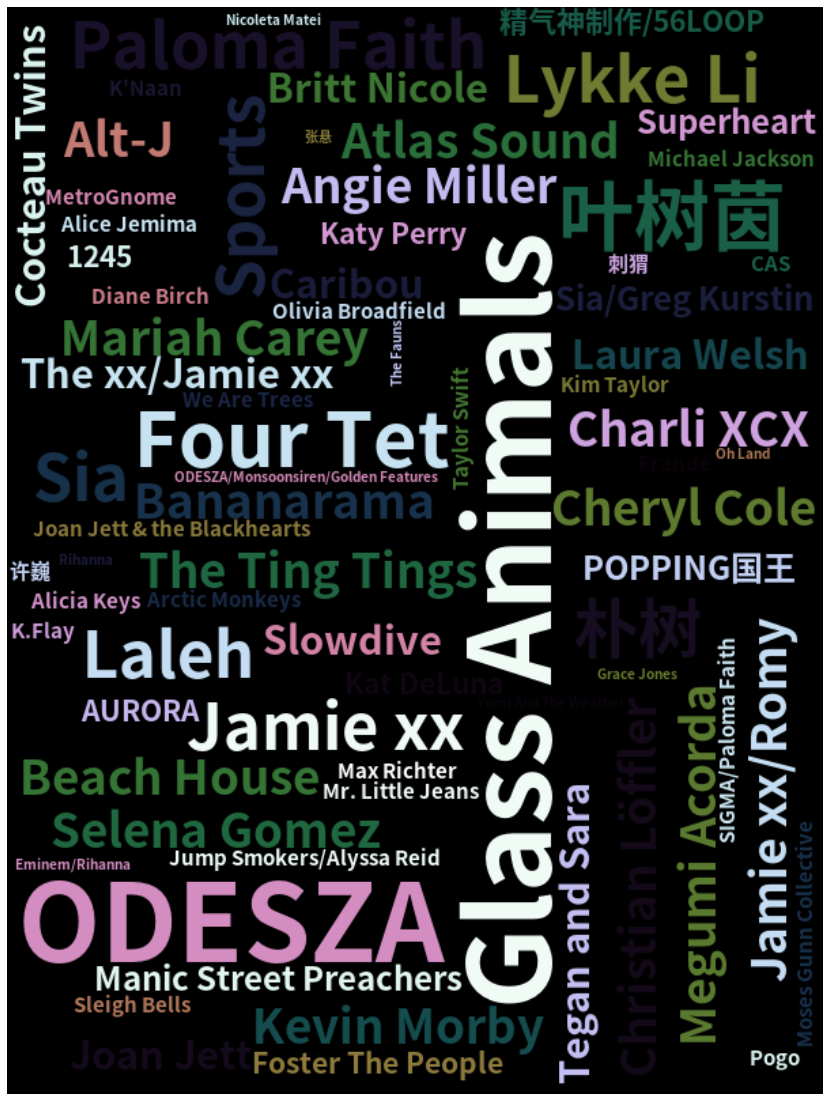

In [72]:
"""
下面生成歌手词云图，歌手频次越高字体越大

WordCloud 默认字体不支持中文，需额外提供中文字体，这里使用思源黑体，也可以下载别的放在路径中使用

下面没有使用mask，如果使用，可以生成 mask 图片形状的词云图，如心形，需注意 mask 图片的背景不能是透明的

colormap 会影响词云图中字体的颜色，有多种colormap可以选择，打开这个链接：https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html，选择其中某种 colormap 将名字输入就可以看到颜色效果，这里选用的是'cubehelix'

关于词云WordCloud的更多参数，参考文档https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html
"""

font_path = './NotoSansCJK-Bold.ttc'            # 给定中文字体，思源黑体
singer_freq = list_freq()
#mask = np.array(Image.open('./img/fmask.png'))  # 提取 mask 图片
singer_wc = WordCloud(mask = None, width=600, height=800, font_path=font_path, colormap='cubehelix', max_words=1000).generate_from_frequencies(singer_freq)  # 生成词云
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(singer_wc,interpolation='bilinear')
plt.savefig('./singers.png',dpi=300, facecolor='k', bbox_inches='tight')    # facecolor决定图片背景是黑色（默认为白色，因词云背景为黑，图片就会有白色边框，所以设为黑色，两者统一），bbox_inches设为tight，是为了将边框设为最窄，dpi决定清晰度




**歌曲词云**

<div class="alert alert-block alert-warning">
<b>说明：</b> 下面一栏定义函数的代码直接运行即可。
</div>

In [73]:
def list_weight():
    """
    得到100首歌的歌名以及对应的权重（即听歌排行中的排序），最终生成的是一个字典，键是歌曲名，值是排序
    """
    with open('mysongs100.txt','r') as file:
        lines = file.readlines()
        song_weight = {}
        for i in lines:
            song = i.split(',')[1][2:-1]
            weight = int(i.split(',')[0][1:])
            song_weight[song]=weight
    return song_weight


<div class="alert alert-block alert-danger">
<b>说明：</b> 说明与上面歌手词云图相同。
</div>

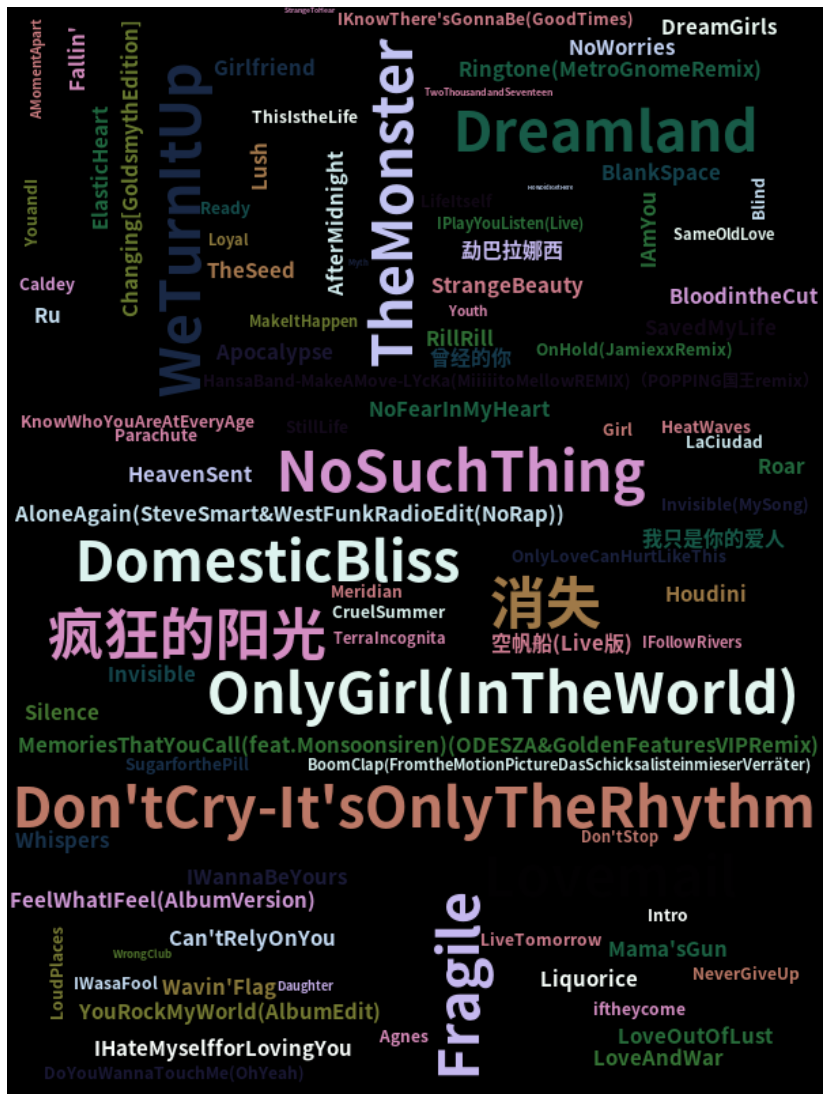

In [78]:
font_path = './NotoSansCJK-Bold.ttc'            # 给定中文字体，思源黑体
song_weight = list_weight()
mask = np.array(Image.open('./img/fmask.png'))  # 提取 mask 图片
song_wc = WordCloud(mask = None, width=600, height=800, font_path=font_path, colormap='cubehelix', max_words=1000).generate_from_frequencies(song_weight)  # 生成词云
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(song_wc,interpolation='bilinear')
plt.savefig('./songs.png',dpi=300, facecolor='k', bbox_inches='tight')    # facecolor决定图片背景是黑色（默认为白色，因词云背景为黑，图片就会有白色边框，所以设为黑色，两者统一），bbox_inches设为tight，是为了将边框设为最窄
